# Dynamic Time Warping

**Objetivos**
1. Implementar o algoritmo de DTW
1. Entender a diferença entre performances da mesma música

**Resultado Esperado**
1. Entendimento do Cromagrama
1. Entedimento da tarefa de alinhamento de músicas

In [1]:
from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

plt.ion()

In [2]:
import warnings; warnings.simplefilter('ignore')

## Introdução

Como vimos em sala de aula, a tarefa de alinhamento de músicas tem diversas aplicações possíveis. Neste notebook, vamos explorar o conceito de *Dynamic Time Warping* para comparar diferentes versões de uma mesma música.

Em tarefas de Recuperação de Informação Musical, é comum comparar duas sequências de comprimentos diferentes. Por exemplo, um objetivo simples pode ser em calcular uma medida de similaridade entre duas versões da mesma música. Em outras palavras, entre dois sinais $x$ e $y$.

Tais sinais podem ter sequências semelhantes de progressões de acordes e instrumentações. Porém, podem haver desvios de batidas por minuto entre os dois. Para entender melhor, compare as duas versões da mesma música abaixo.

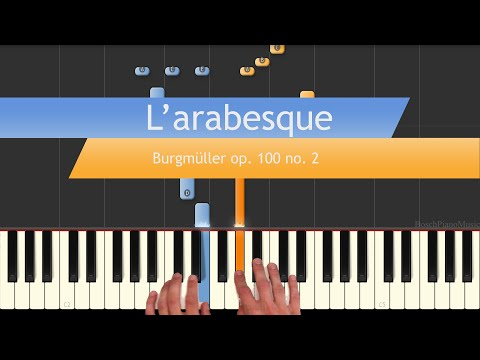

In [3]:
ipd.YouTubeVideo('ZTJ0AYKNdgI')

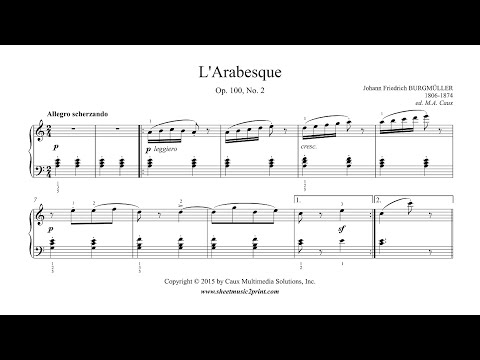

In [4]:
ipd.YouTubeVideo('1oMm_n38OxQ')

Observe como cada versão diferente tem uma duração distinta. Mesmo que expressássemos os dois sinais de áudio usando o mesmo espaço de recursos (por exemplo, espectrogramas), não poderíamos simplesmente usar uma distâncias entre pares simples. Os sinais têm comprimentos diferentes (4 segundos de diferença).

Como visto em sala de aula, o problema de alinhamento de músicas tem diversas aplicações nas bibliotecas digitais musicais. Uma delas, são aplicativos que permitem o chaveamento entre diferentes versões em um mesmo instante de tempo (na mesma nota). Uma outra é a análise de performance.

Para alinhar músicas vamos fazer uso de *Dynamic Time Warping*.

## Dynamic Time Warping

### Do Wikipedia

Dynamic time warping (DTW) é um algoritmo para comparar e alinhar duas séries temporais. A DTW é utilizada para encontrar o alinhamento não-linear ótimo entre duas sequências de valores numéricos. Dessa maneira, é possível encontrar padrões entre medições de eventos com diferentes ritmos. Por exemplo, é possível casar a série temporal obtida por acelerômetros (ou outros sensores) de duas pessoas andando em diferentes velocidades.

DTW pode ser utilizada para alinhar qualquer tipo de dado que obedeça uma ordem temporal, como vídeo, áudio e imagens. Entre as diversas aplicações da DTW, encontra-se o reconhecimento de fala e de assinatura, bem como o alinhamento de gravações musicais com suas respectivas partituras.

**Exemplo**

Para entender o algoritmo, vamos criar duas vetores de tamanhos distintos.

In [5]:
x = np.array([1, 4, 4, 2, -4, -4, 9])
y = np.array([1, 3, 4, 3, 1, -1, -2, -1, 12])
nx = len(x)
ny = len(y)

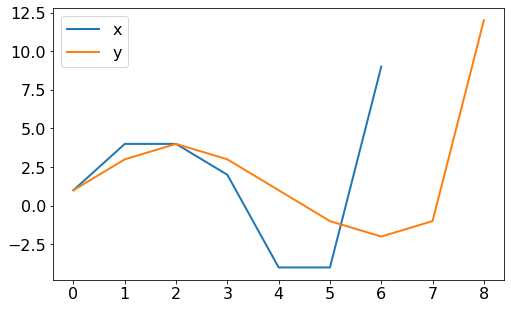

In [6]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
ax.plot(x)
ax.plot(y)
ax.legend(('x', 'y'))

Neste exemplo simples, há apenas um valor ou "atributo" em cada índice de tempo. Na prática, você pode usar sequências de vetores, por exemplo, espectrogramas ou cromogramas.

### Distância

O DTW requer o uso de uma métrica de distância entre as observações correspondentes de $x$ e $y$. 

**Euclidiana**

Uma escolha comum é a distância euclidiana.

$$d(\mathbf{f}_1, \mathbf{f}_2) = || \mathbf{f}_1 - \mathbf{f}_2 || = \sqrt{\sum_i (\mathbf{f}_1[i] - \mathbf{f}_2[i])^2}$$

Observe como os vetores aqui tem as mesmas dimensões. Tal dimensão **não é o tempo**, sim o **número de observações por tempo**. No exemplo acima temos apenas uma observação por tempo. Porém, ao fazer o cromagrama de uma música, vide abaixo, teremos 12 observações por tempo.

No exemplo abaixo temos duas observações por tempo.

In [7]:
import scipy.spatial as ss
ss.distance.euclidean([1, 0], [5, 12])

12.649110640673518

**Coseno**

Uma outra métrica de distância é o 1-coseno. Quando dois vetores apontam na mesma direção, o coseno entre os mesmos é 1. Quando apontam em direções opostas, o coseno vira 0. Assim, vamo fazer 1-coseno vamos capturar uma noção de distância que não se importa com a magnitude dos valores, sim com a direção dos vetores.

![](./cos.png)

In [8]:
ss.distance.cosine([1, 0], [5, 12])

0.6153846153846154

Observe que magnitudes diferentes apontando na mesma direção dão o mesmo resultado.

In [9]:
ss.distance.cosine([1, 1], [9, 9])

0.0

### Cromagrama

Como vimos em sala de aula, podemos usar o **cromagrama**, ou **vetor de cromas**, para representar músicas. Um vetor de croma é um vetor de característica de 12 elementos. Cada elemento indica a quantidade de energia em um *semitom* {C, C #, D, D #, E, ..., B}.

Vamos comparar dois vetores de croma da mesma música usando librosa.

Carregando uma música com librosa. Vamos focar nos primeiros 15 segundos da música apenas. Nossa comparação será de duas versões da música [Body and Soul](https://en.wikipedia.org/wiki/Body_and_Soul_(1930_song)). 

**Do Wikipedia**

"Body and Soul" foi escrita para a atriz e cantora inglesa Gertrude Lawrence, sendo interpretada pela primeira vez por ela, ainda na Inglaterra. Libby Holman foi a responsável pelo lançamento da canção nos Estados Unidos. Inicialmente, a música foi proibida de ser executada nas estações de rádio do país, porém a popularidade da canção cresceu muito nas décadas de 1930 e 1940, sendo regravada por uma série de artistas. A primeira regravação de "Body and Soul" foi feita ainda em 1930 pelo cantor estadunidense Louis Armstrong, que após o seu lançamento alcançou o número 12 na parada de singles norte-americana. Até o final da década, a canção havia sido regravada por 11 grupos, senda a mais bem-sucedida nas paradas a versão original da canção lançada por Libby Holman tando atingido o número 3. "Body and Soul" continua a ser um padrão de jazz, com centenas de versões cantadas e gravadas por dezenas de artistas. Clássicas gravações vocais incluem as de: Ella Fitzgerald, Hanshaw Annette, Billie Holiday, Billy Eckstine , Etta James , Sarah Vaughan e Frank Sinatra, e músicos como Benny Goodman, Lee Konitz, John Coltrane, Charles Mingus, Dexter Gordon, Sonny Stitt e Lester Young.

**MP3s**

Na pasta `mp3s` existem diferentes versões de Body and Soul. As mesmas foram identificadas com ajuda da base de dados chamada de [JazzTube](http://mir.audiolabs.uni-erlangen.de/jazztube). O JazzTube contém um série de referências a clássicos do Jazz no YouTube. Caso queira, explore a base pois pode ser uma fonte para projetos futuros.

O professor da disciplina baixou os mp3s do YouTube usando a ferramenta [youtube-dl](https://youtube-dl.org/). Abaixo segue um exemplo de uso da mesma, não precisa executar.

```bash
$ youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=_OFMkCeP6ok
```

*Abaixo uma versão antiga de Chu Berry e Roy Eldridge*

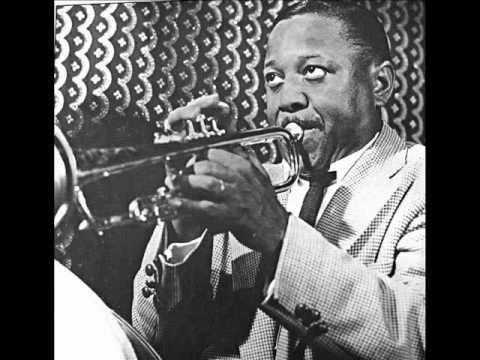

In [10]:
ipd.YouTubeVideo('Lor80WUVbtw')

In [11]:
wave_classic, sr = librosa.load('mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3',
                                duration=15)

Vamos computar o cromograma da música com librosa.

In [12]:
chroma_classic = librosa.feature.chroma_stft(wave_classic, sr=sr)
chroma_classic.shape

(12, 646)

Plotar o mesmo.

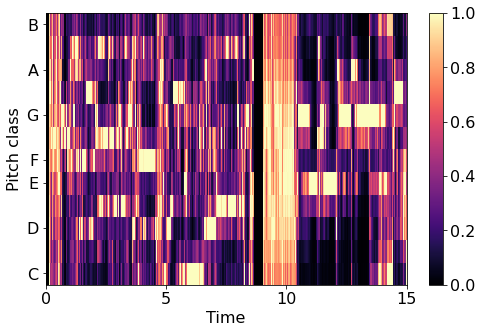

In [13]:
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

*Agora uma versão mais nova de Tony Bennett e Amy Winehouse*

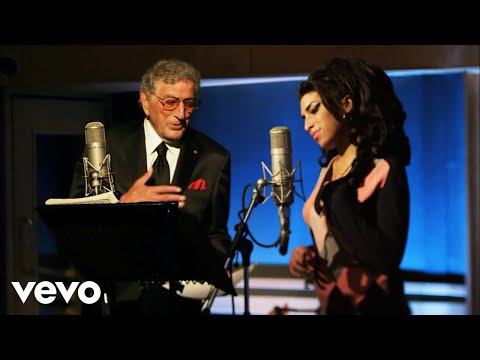

In [14]:
ipd.YouTubeVideo('_OFMkCeP6ok')

Tanto em áudio quanto em cromagrama, as duas versões são bem diferentes.

In [15]:
wave_amy, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                        duration=15)

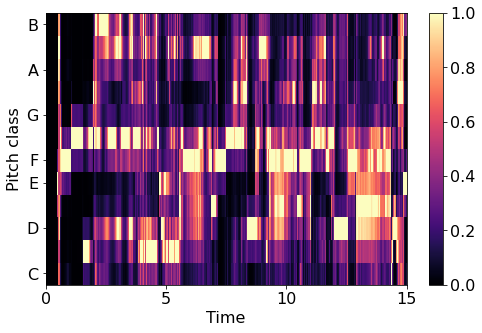

In [16]:
chroma_amy = librosa.feature.chroma_stft(wave_amy, sr=sr)
chroma_amy.shape
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Para comparar as duas com DTW, temos que computar a distância coseno entre as colunas.

In [17]:
print(chroma_classic[:, 0].shape)
print(chroma_amy[:, 0].shape)

(12,)
(12,)


Aqui observamos nosso primeiro problema, a presença de zeros leva a disância para `nan`. Portanto, é mais comum usar versões suavizadas do cromagrama.

In [18]:
ss.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

nan

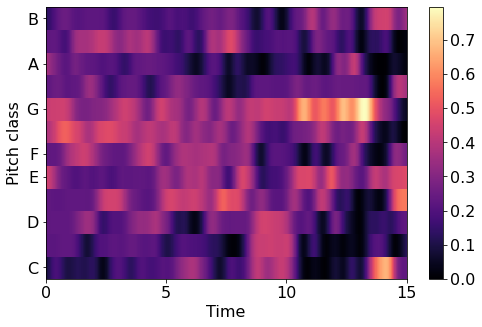

In [19]:
chroma_classic = librosa.feature.chroma_cens(wave_classic, sr=sr)
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

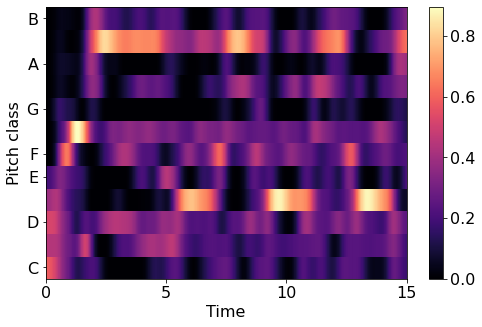

In [20]:
chroma_amy = librosa.feature.chroma_cens(wave_amy, sr=sr)
fig, ax = plt.subplots(figsize=(1.618 * 5, 5))
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Qual foi a ideia? Veja os slides das aula.

1. Tirar o log para ficar em uma *escala mais musical*
1. Somar uma pequena constante
1. Normalizar as colunas
1. Dentre outros

In [21]:
ss.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

0.5731591314954412

## Tarefa 1

Agora vamos programar. Sua primeira tarefa é implementar o Dynamic Time Warping. Seu código deve fazer uso de duas funções, uma para computar a matriz de custo. Esta se chama `dtw_table` abaixo. Pode usar a distância euclideana por simplicidade. 

![](./saida1.png)

**Questão 1**

Seu código deve gerar uma saída como a acima. Caso fique igual, 100%. Observe que a mesma não corresponde as saída do livros, Python indexa de cima para baixo. O livro de baixo para cima. De qualquer forma, isto é apenas um pequeno detalhe que não muda o algoritmo. Caso queira, mude o código para receber uma função de distância.

Seu código abaixo já vai receber matrizes onde as colunas são tempo e as linhas são observações.

In [22]:
def dtw_table(X, Y, distance_function=ss.distance.euclidean):
    '''
    Retorna a matriz de DTW entre as músicas.
    
    Argumentos
    ----------
    X: matriz onde as colunas são tempo e as linhas são atributos
    Y: matriz onde as colunas são tempo e as linhas são atributos
    ''' 
    nx = X.shape[1]
    ny = Y.shape[1]
    
    # Os tempos de Y estão pelas colunas de D
    # Os tempos de X estão pelas linhas de D
    D = np.zeros(shape=(nx, ny), dtype='d')
    D.fill(np.nan)      # NaN's só para assegurar que estamos preenchendo
    
    # Inicializar a primeira coluna e a primeira linha como os custos somente
    # Primeira coluna: custo de atribuir o i-ésimo tempo de X ao tempo 0 de Y
    for i in range(nx):
        D[i,0] = distance_function(X[:, i], Y[:, 0])
    # Primeira linha: custo de atribuir o tempo 0 de X ao j-ésimo tempo de Y  
    for j in range(ny):
        D[0,j] = distance_function(X[:, 0], Y[:, j])

    # Iterar de (1,1) em diante para saber os outros custos
    # Lembrando que começamos a indexar de 0
    for i in range(1,nx):
        for j in range(1,ny):
            base_cost = distance_function(X[:, i], Y[:, j])
            # print("Custo Base de (",i,j,"): ", base_cost)
            # print("\tCusto -1,-1: ", D[i-1,j-1])
            # print("\tCusto 0,-1: ", D[i,j-1])
            # print("\tCusto -1,0: ", D[i-1,j])
            cost = base_cost + min(D[i-1,j-1],D[i,j-1],D[i-1,j])
            D[i,j] = cost
    return D

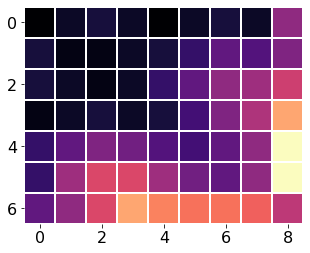

In [23]:
def plot_dtw_table(D, path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(D, cmap='magma')
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks(np.arange(D.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(D.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    if path:
        x = []
        y = []
        for n, m in path:
            y.append(n)
            x.append(m)
        ax.plot(x, y, color='r')
    
D = dtw_table(x[None], y[None]) # Não apagar isto é o teste!!!
plot_dtw_table(D)

**Questão 2**

Agora, crie uma função que retorna uma lista de tuplas. Esta lista contém o caminho ótimo do DTW. Para o exemplo acima com distância euclidiana, o caminho é:

```
[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]
 ```
 
O plot agora deve ficar estilo a figura abaixo.

![](./saida2.png)

[(6, 8), (5, 7), (5, 6), (4, 5), (3, 4), (3, 3), (2, 2), (1, 2), (1, 1), (0, 0)]


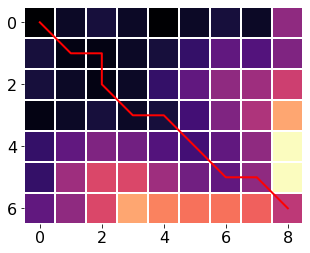

In [24]:
def dtw(X, Y):
    if X.ndim == 1:
        X = X[None]
        Y = Y[None]
        
    D = dtw_table(X, Y)
    
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    n = n_x - 1
    m = n_y - 1
    path = [(n, m)]
    
    while n > 0 or m > 0:
        if n == 0:
            while m > 0:
                m = m - 1
                path += [(n, m)]

        if m == 0:
            while n > 0:
                n = m - 1
                path += [(n, m)]
                
        if D[n - 1, m - 1] < D[n - 1, m] and D[n - 1, m - 1] < D[n, m - 1]:
            n = n - 1
            m = m - 1
        elif D[n - 1, m] < D[n, m - 1]:
            n = n - 1
        else:
            m = m - 1
        path += [(n, m)]
    return D, path

D, path = dtw(x, y)
print(path)
plot_dtw_table(D, path)

## Tarefa 2

Usando a biblioteca [FastDTW](https://github.com/slaypni/fastdtw) ordena as versões das músicas que são mais e menos similares com a versão de Tony Bennet e Amy Winehouse

```bash
$ pip install fastdtw
```

A biblioteca FastDTW é interessante pois é toda linear em tempo e memória. Assim, podemos computar a distância entre versões inteiras de músicas. Faça isso. Caso não execute, trunque em 2mins. Caso não execute, trunque em 1 min.

Abaixo executo a FastDTW com os 15 segundos que carregamos antes. Observe como passo a transposta, pois a biblioteca funciona em linhas, não em colunas, como o livro.

In [25]:
from fastdtw import fastdtw
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(chroma_amy.T, chroma_classic.T, dist=ss.distance.cosine)

In [26]:
distance

202.5964747596338

In [27]:
path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 39),
 (41, 39),
 (42, 39),
 (43, 39),
 (44, 39),
 (45, 39),
 (46, 39),
 (47, 39),
 (48, 39),
 (49, 39),
 (50, 39),
 (51, 39),
 (52, 39),
 (53, 39),
 (54, 39),
 (55, 39),
 (56, 39),
 (57, 39),
 (58, 39),
 (59, 39),
 (60, 39),
 (61, 39),
 (62, 39),
 (63, 40),
 (64, 41),
 (65, 42),
 (66, 43),
 (67, 44),
 (68, 45),
 (69, 46),
 (70, 47),
 (71, 48),
 (72, 49),
 (73, 50),
 (74, 51),
 (75, 52),
 (76, 53),
 (77, 54),
 (78, 55),
 (79, 56),
 (80, 57),
 (81, 58),
 (82, 59),
 (83, 60),
 (84, 61),
 (85, 62),
 (86, 63),
 (87, 64),
 (88, 65),
 (89, 66),
 (90, 67),
 (91, 68),
 (92, 69

In [28]:
# Pega a lista de músicas da pasta mp3s
import os

mp3s = []
for filename in os.listdir("mp3s/"):
    if filename.endswith(".mp3"): 
        mp3s.append(filename)
        continue
    else:
        continue

In [29]:
# Get recent version for comparison
recent_idx = mp3s.index('Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3')
recent = mp3s[recent_idx]
mp3s.remove('Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3')
mp3s

['John Coltrane Quartet - Body And Soul-62FQT9PXWM4.mp3',
 'Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3',
 'Stan Getz - Body and Soul-qPJpP2mxbsg.mp3',
 'Chuck Berry _ Roy Eldridge- Body and Soul-0i5jQAAL60Y.mp3',
 '♪ Body and Soul (Alternate take) _ John Coltrane-q4XdeSN4rCI.mp3',
 'Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3',
 'Stan Getz Quintet - Body And Soul (Norgran Records 1952)-C2QwjXQMIZE.mp3',
 'JOHN COLTRANE - BODY AND SOUL-jUUNYtSkseI.mp3',
 'John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3',
 'David Murray Quartet - Body And Soul (Duet)-p0tEqbNHi64.mp3',
 'Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3',
 'Coleman Hawkins-Body and Soul 1939.wmv-Sul_9BcgOOI.mp3',
 'Body and soul Don Byas-402zBdIdmNU.mp3',
 'Stan Getz - Body and Soul-J5hZUnDhlhg.mp3']

In [30]:
# Computes chromagram for recent version
wave_recent, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                              duration=120)
chroma_recent = librosa.feature.chroma_cens(wave_recent, sr=sr)

In [31]:
# Computes chromagram for each version
chromas = []
distances = []
paths = []
for musicfile in mp3s:
    wave, sr = librosa.load('mp3s/'+musicfile, duration=120)
    chroma = librosa.feature.chroma_cens(wave, sr=sr)
    chromas.append(chroma)
    distance, path = fastdtw(chroma_recent.T, chroma.T, dist=ss.distance.cosine)
    distances.append(distance)
    paths.append(path)
    print("Done ", musicfile)

Done  John Coltrane Quartet - Body And Soul-62FQT9PXWM4.mp3
Done  Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3
Done  Stan Getz - Body and Soul-qPJpP2mxbsg.mp3
Done  Chuck Berry _ Roy Eldridge- Body and Soul-0i5jQAAL60Y.mp3
Done  ♪ Body and Soul (Alternate take) _ John Coltrane-q4XdeSN4rCI.mp3
Done  Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3
Done  Stan Getz Quintet - Body And Soul (Norgran Records 1952)-C2QwjXQMIZE.mp3
Done  JOHN COLTRANE - BODY AND SOUL-jUUNYtSkseI.mp3
Done  John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3
Done  David Murray Quartet - Body And Soul (Duet)-p0tEqbNHi64.mp3
Done  Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3
Done  Coleman Hawkins-Body and Soul 1939.wmv-Sul_9BcgOOI.mp3
Done  Body and soul Don Byas-402zBdIdmNU.mp3
Done  Stan Getz - Body and Soul-J5hZUnDhlhg.mp3


In [32]:
similarity = list(zip(distances, mp3s))
similarity.sort(reverse=True, key=lambda x: x[0])

In [33]:
similarity

[(1686.1651649572796,
  'Chuck Berry _ Roy Eldridge- Body and Soul-0i5jQAAL60Y.mp3'),
 (nan, '♪ Body and Soul (Alternate take) _ John Coltrane-q4XdeSN4rCI.mp3'),
 (1583.1910730670013,
  'David Murray Quartet - Body And Soul (Duet)-p0tEqbNHi64.mp3'),
 (1489.1478155083607,
  'Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3'),
 (1459.0086493997233, 'Body and soul Don Byas-402zBdIdmNU.mp3'),
 (1427.027322247975, 'Coleman Hawkins-Body and Soul 1939.wmv-Sul_9BcgOOI.mp3'),
 (1362.2516510200348, 'Stan Getz - Body and Soul-qPJpP2mxbsg.mp3'),
 (1351.8097610241052, 'Stan Getz - Body and Soul-J5hZUnDhlhg.mp3'),
 (1347.6040385082026,
  'Stan Getz Quintet - Body And Soul (Norgran Records 1952)-C2QwjXQMIZE.mp3'),
 (1341.4162671602076, 'Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3'),
 (1334.326774194718, 'Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3'),
 (1326.187161098341, 'John Coltrane Quartet - Body And Soul-62FQT9PXWM4.mp3'),
 (1307.6957430300988, 'John Coltrane _Body And Soul_

**Questão 1**

Ordene as músicas por similaridade com a versão mais recent (Bennet e Winehouse). Indique sua resposta abaixo.

> Sua respota. Ou seja, os ids do YouTube aqui do mais até o menos similar. Escute as músicas, você percebe a similaridade? Em quais aspectos?

**Questão 2**

Plote o caminho de sincronização da música mais e menos similar. Isto é, no eixo-x você pode usar o tempo da música referência (Bennet e Winehouse). No eixo-y, o tempo das outras músicas. 

> Qual interpretação você tira do plot?

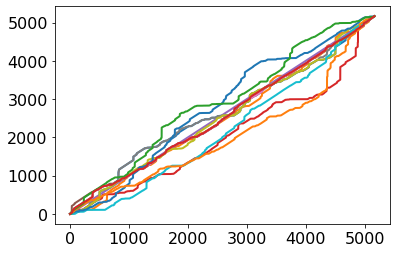

In [62]:
for path in paths:
    x,y = list(zip(*path))
    plt.plot(x,y)

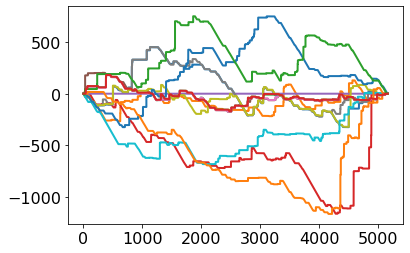

In [74]:
for path in paths:
    x,y = list(zip(*path))
    y = np.array(y)-np.array(x)
    plt.plot(x,y)

**Questão 3**

Plote os cromagramas da músicas mais e menos similar. Compare com a versão base.

> Qual interpretação você tira do plot?

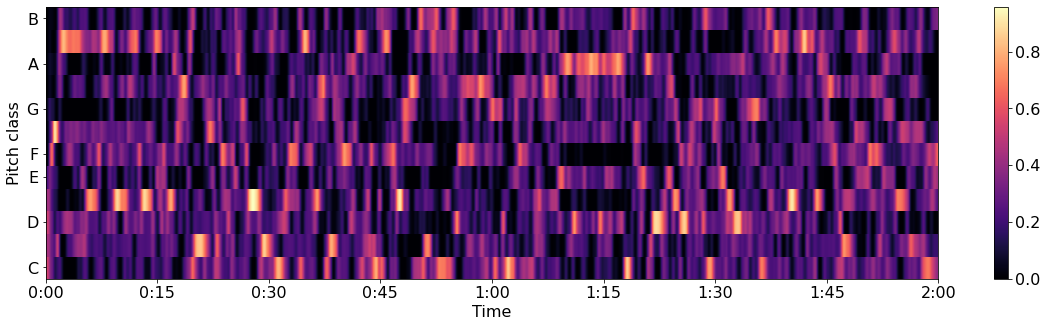

In [70]:
fig, ax = plt.subplots(figsize=(4 * 5, 5))
img = librosa.display.specshow(chroma_recent,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

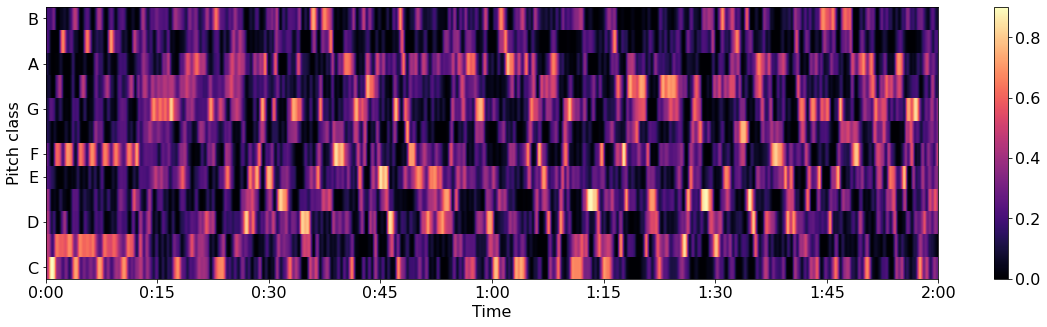

In [71]:
fig, ax = plt.subplots(figsize=(4 * 5, 5))
img = librosa.display.specshow(chromas[3],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

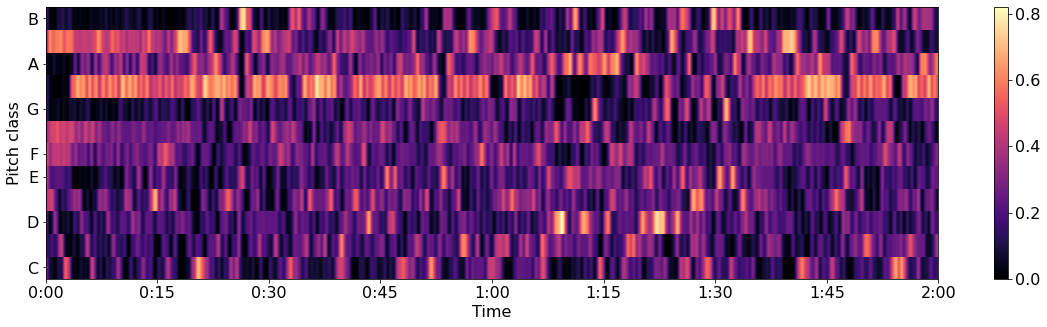

In [72]:
fig, ax = plt.subplots(figsize=(4 * 5, 5))
img = librosa.display.specshow(chromas[7],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

A similar realmente parece, tem alguns artefatos que se repetem (linha do A em +- 1:15), a menos similar é bastante diferente

# OFF

In [31]:
def similarity(music1, music2):
    wave1, sr = librosa.load(music1)
    chroma1 = librosa.feature.chroma_ft(wave1, sr=sr)
    
    wave2, sr = librosa.load(music2)
    chroma2 = librosa.feature.chroma_stft(wave2, sr=sr)
    
    distance, path = fastdtw(chroma1.T, chroma2.T, dist=ss.distance.cosine)
    return distance,path

In [ ]:
directory = 'mp3s/'
music1 = directory + 'Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3'
music2 = directory + mp3s[0]

similarity(music1, music2)

In [ ]:
distance, path = fastdtw(chroma_recent.T, chromas[0].T, dist=ss.distance.cosine)
distance, path = fastdtw(chroma_recent.T, chromas[1].T, dist=ss.distance.cosine)

In [ ]:
# Computes fastDTW for each version compared to recent
distances = []
paths = []
for chrom in chromas:
    distance, path = fastdtw(chroma_recent.T, chrom.T, dist=ss.distance.cosine)
    distances.append(distance)
    paths.append(path)

In [ ]:
with open('mp3s/body-urls.txt') as f:
    lines = f.readlines()

urls
for line in lines    
    lines